# Image Classification on Pneumonia Chest Xray's

### Steps
- load and normalize data
    - define transforms, dataset and dataloaders
    - find mean and std
- visualize images
- define train function
- define visualize function


In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

In [3]:
import os
import copy 
import time
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [5]:
import torchvision
from torchvision import transforms, datasets, models

In [6]:
plt.ion()

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## load and normalize the data

In [8]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5528, 0.5528, 0.5528], [0.1583, 0.1583, 0.1583])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5528, 0.5528, 0.5528], [0.1583, 0.1583, 0.1583])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5528, 0.5528, 0.5528], [0.1583, 0.1583, 0.1583])
    ])
}

In [9]:
path = './data/chest_xray/'

**datasets**

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), transform[x]) 
                  for x in ['train', 'val', 'test']}

**data loader**

In [18]:
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1 if x == 'val' else 64, 
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val', 'test']}

**number of images**

In [12]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

{'test': 624, 'train': 5216, 'val': 16}

**classes**

In [13]:
class_names = image_datasets['train'].classes
class_names

['NORMAL', 'PNEUMONIA']

**mean and std**

In [17]:
mean = 0.
std = 0.

# use large batch size just for finding mean and std
for images, labels in data_loaders['train']:
    images, labels = images.to(device), labels.to(device)
    
    # get number of images in the batch and number of channels
    batch_samples = images.size(0)
    nb_channels = images.size(1)
    # flatten height and width into one axis
    images = images.view(batch_samples, nb_channels, -1)
    # get mean and std
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    
mean /= dataset_sizes['train']
std /= dataset_sizes['train']

print('mean: ', mean)
print('std: ', std)

mean:  tensor([0.5528, 0.5528, 0.5528], device='cuda:0')
std:  tensor([0.1583, 0.1583, 0.1583], device='cuda:0')


## visualize some images

In [14]:
def imshow(img, title=None):
    # convert from tensor to numpy array
    inp = img.numpy().transpose((1, 2, 0))
    # mean and std used for normalization
    mean = np.array([0.5528, 0.5528, 0.5528])
    std = np.array([0.1583, 0.1583, 0.1583])
    # unnormalize
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

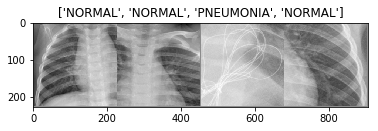

In [17]:
train_iter = iter(data_loaders['train'])
images, labels = train_iter.next()

grid = torchvision.utils.make_grid(images)
title = [class_names[x] for x in labels]

imshow(grid, title=title)

## define train function

In [41]:
def train(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        # each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train': 
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.
            running_corrects = 0.
            # iterate over the images
            for images, labels in data_loaders[phase]:
                images, labels = images.to(device), labels.to(device)
                # zero the gradient parameters
                optimizer.zero_grad()
                
                # forward pass
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    
                    # backward + optimize if only in training 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # stats 
                running_loss += loss.item() * labels.size(0)
                running_corrects += (preds == labels).sum().item()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('{} Loss: {:.4f}  Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_model_wts = copy.deepcopy(model.state_dict())
                best_acc = epoch_acc
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best validation acc: {:.4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### generic function to display predictions for a few images

In [57]:
def visualize_model(model, num_images=6):
    was_training = model.training
    images_so_far = 0
    model.eval()
    fig = plt.figure()
    
    with torch.no_grad():
        for images, labels in data_loaders['val']:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for j in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(images.cpu().data[j])
                
            if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## define and freeze model

In [43]:
model = torchvision.models.resnet34(pretrained=True)

freeze weights

In [44]:
for param in model.parameters():
    param.requires_grad = False

replace fully connected layer

In [45]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

## define loss function

In [46]:
criterion = nn.CrossEntropyLoss()

## define optimizer

In [47]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

**define scheduler**

In [48]:
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

## Train

In [49]:
model = train(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 0.4227  Acc: 0.8140
val Loss: 0.8145  Acc: 0.6250

Epoch 2/10
----------
train Loss: 0.2993  Acc: 0.8696
val Loss: 0.7692  Acc: 0.6875

Epoch 3/10
----------
train Loss: 0.2704  Acc: 0.8817
val Loss: 1.0234  Acc: 0.6250

Epoch 4/10
----------
train Loss: 0.2584  Acc: 0.8878
val Loss: 0.7237  Acc: 0.6875

Epoch 5/10
----------
train Loss: 0.2564  Acc: 0.8894
val Loss: 0.8669  Acc: 0.6875

Epoch 6/10
----------
train Loss: 0.2494  Acc: 0.8932
val Loss: 0.9930  Acc: 0.6875

Epoch 7/10
----------
train Loss: 0.2562  Acc: 0.8900
val Loss: 0.9717  Acc: 0.6875

Epoch 8/10
----------
train Loss: 0.2334  Acc: 0.9034
val Loss: 0.9934  Acc: 0.6875

Epoch 9/10
----------
train Loss: 0.2373  Acc: 0.8970
val Loss: 0.9240  Acc: 0.6875

Epoch 10/10
----------
train Loss: 0.2322  Acc: 0.9059
val Loss: 0.9362  Acc: 0.6875

Training complete in: 6m 2s
Best validation acc: 0.6875


## fine tuning

In [51]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [52]:
model = train(model, criterion, optimizer, scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.2082  Acc: 0.9199
val Loss: 0.8834  Acc: 0.6250

Epoch 2/25
----------
train Loss: 0.1467  Acc: 0.9459
val Loss: 0.1126  Acc: 0.9375

Epoch 3/25
----------
train Loss: 0.1323  Acc: 0.9523
val Loss: 0.5136  Acc: 0.6875

Epoch 4/25
----------
train Loss: 0.1214  Acc: 0.9538
val Loss: 0.2325  Acc: 0.9375

Epoch 5/25
----------
train Loss: 0.0970  Acc: 0.9638
val Loss: 0.6927  Acc: 0.6250

Epoch 6/25
----------
train Loss: 0.0970  Acc: 0.9664
val Loss: 0.4323  Acc: 0.8125

Epoch 7/25
----------
train Loss: 0.0898  Acc: 0.9686
val Loss: 0.3726  Acc: 0.8750

Epoch 8/25
----------
train Loss: 0.0933  Acc: 0.9651
val Loss: 0.4868  Acc: 0.8750

Epoch 9/25
----------
train Loss: 0.0881  Acc: 0.9676
val Loss: 0.4423  Acc: 0.8750

Epoch 10/25
----------
train Loss: 0.0766  Acc: 0.9716
val Loss: 0.2347  Acc: 0.8750

Epoch 11/25
----------
train Loss: 0.0750  Acc: 0.9728
val Loss: 0.4326  Acc: 0.8750

Epoch 12/25
----------
train Loss: 0.0766  Acc: 0.9712
val Loss

## evaluate

In [55]:
correct = 0 
total = 0

with torch.no_grad():
    for images, labels in data_loaders['test']:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        
acc = (correct / total) * 100
print('Test accuracy: {:.2f}%'.format(acc))

Test accuracy: 92.79%


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f59187c6898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/usr/local/lib/python3.5/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File

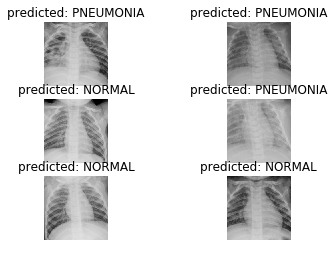

In [58]:
visualize_model(model)